In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import squidpy as sq

/software/cellgen/team205/kk18/envs/squidpy/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/software/cellgen/team205/kk18/envs/squidpy/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/software/cellgen/team205/kk18/envs/squidpy/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
# import session_info
# session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/tissueaxis.py")
tissueaxis = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = tissueaxis
spec.loader.exec_module(tissueaxis)

In [4]:
sc.settings.set_figure_params(dpi=120)

# Variables

In [5]:
adata_dir = '/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects'
sample_id = 'HEA_FOET14880396'

In [6]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

In [7]:
celltype_key = 'fine_grain_4Jan2025'
axis_name = 'SAN_axis'

# Read in data

bin2cell output which has celltypist output as well

In [8]:
# read in 
adata = sc.read_h5ad(f'{adata_dir}/{sample_id}_b2c_cells_filtered_lognorm.h5ad')
adata

AnnData object with n_obs × n_vars = 129803 × 18047
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'fine_grain_4Jan2025', 'HistologicalAnnotation', 'SANaxis_landmarks', 'SAN_axis', 'SAN_axis_bin_annot'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HistologicalAnnotation_colors', 'cell

In [9]:
# celltype name mapping for plotting
df = pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/finegrain_name_mapping.csv')
celltype_mapping = df.set_index('Full_name')['Short_name_finalised'].to_dict()
adata.obs.replace({'fine_grain_4Jan2025':celltype_mapping},inplace=True)

/tmp/ipykernel_1580522/3810385248.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs.replace({'fine_grain_4Jan2025':celltype_mapping},inplace=True)


# Detect spatial neighbours

In [10]:
%%time
sq.gr.spatial_neighbors(adata, coord_type="generic", n_neighs=20, spatial_key="spatial")

CPU times: user 988 ms, sys: 122 ms, total: 1.11 s
Wall time: 1.14 s


In [11]:
spatial_connect = adata.obsp['spatial_connectivities'].copy()

In [12]:
# mask for cells which has macrophage pseudotime
mask = adata.obs[f'{axis_name}_bin_annot']!='nan'

In [13]:
spatial_connect[:,mask].shape

(129803, 1510)

In [14]:
# Step 1: Transpose the sparse matrix
sparse_matrix_T = spatial_connect[:,mask].T  

In [15]:
from tqdm import tqdm

In [16]:
# Step 2: Initialize a dictionary to store neighbor cell type counts for each pseudotime cell
neighbor_cell_types = {i: [] for i in range(sparse_matrix_T.shape[0])}
# Step 3: Identify neighbors for each pseudotime cell and aggregate cell types
cell_types = list(adata.obs[celltype_key])
for i in tqdm(range(sparse_matrix_T.shape[0])):
    neighbors = np.nonzero(sparse_matrix_T[i])[1]  # Get indices of neighbors
    neighbor_types = [cell_types[j] for j in neighbors]
    neighbor_cell_types[i].extend(neighbor_types)
# Step 4: Convert to DataFrame for easier analysis
neighbor_df = pd.DataFrame.from_dict(neighbor_cell_types, orient='index')
# Calculate frequency or proportion of each cell type for each pseudotime
cell_type_counts = neighbor_df.apply(pd.Series.value_counts, axis=1).fillna(0)
# add pseudotime
cell_type_counts.index = adata.obs_names[mask]

100%|██████████| 1510/1510 [00:01<00:00, 1035.96it/s]


In [23]:
cell_type_counts[f'{axis_name}_bin_annot']=adata.obs.loc[cell_type_counts.index,f'{axis_name}_bin_annot']
df = cell_type_counts.groupby(f'{axis_name}_bin_annot').mean()
df = df.dropna()
df.max().sort_values(ascending=False)

/tmp/ipykernel_1580522/1380053985.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = cell_type_counts.groupby(f'{axis_name}_bin_annot').mean()


SANPCHd       13.281853
SANPCHn       13.113043
SANPCT        10.009346
aCMR           6.728571
unassigned     5.616822
FB             4.430769
AVNPC          2.859813
GVVenEC        1.127660
Endocard       1.014286
ParaN          0.574468
MesEpiC        0.430769
CorPeri        0.343629
MacCX3         0.324324
aCML           0.288889
CorCapEC       0.287425
SchwC          0.148936
MPLYVE1        0.142857
LymphEC        0.121739
GVSMCT         0.107692
SchwNeuro      0.095745
ValveIC        0.073333
GVSMC          0.046332
EPDC           0.034749
vCMC           0.034749
PericFib       0.023166
ValveEC        0.014286
dtype: float64

In [25]:
cell_type_counts[f'{axis_name}_bin_annot']=adata.obs.loc[cell_type_counts.index,f'{axis_name}_bin_annot']
df = cell_type_counts.groupby(f'{axis_name}_bin_annot').mean()
df = df.dropna()


mean_thresh = 0.1
df = df[df.columns[df.max()>mean_thresh]].T

# normalise with max value
max_arr = df.max(axis=1)
for col in df.columns:
    df[col] = df[col]/max_arr

# remove "unclassified"
df = df[df.index!='unassigned']

/tmp/ipykernel_1580522/3071229161.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = cell_type_counts.groupby(f'{axis_name}_bin_annot').mean()


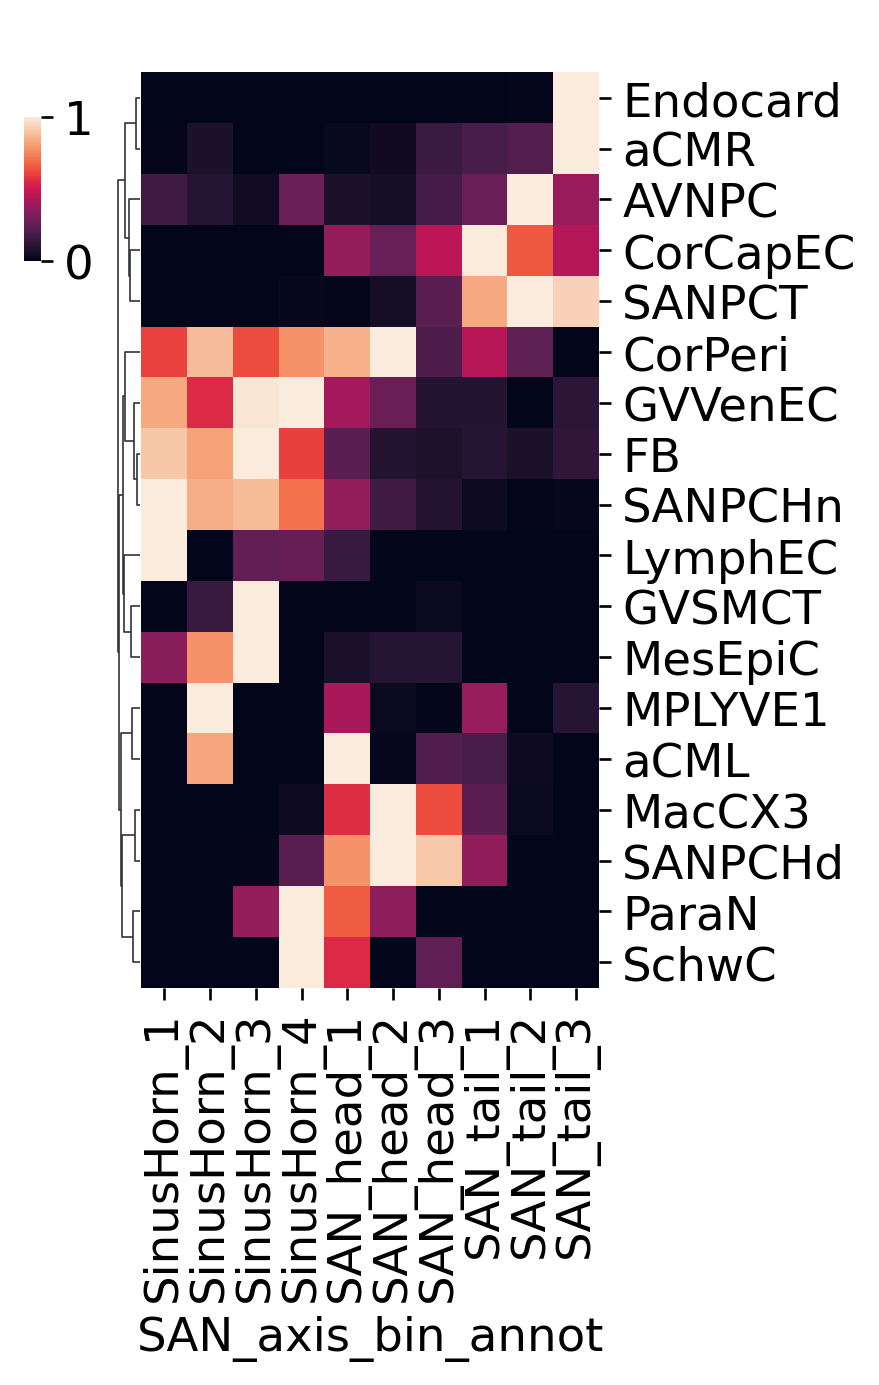

In [29]:
plt.rcParams['axes.grid'] = False
sns.clustermap(df,col_cluster=False,figsize=(3.5,6),
               dendrogram_ratio=0.05,cbar_pos=(-0.05, 0.8, 0.02, 0.1))
plt.savefig(f'{figdir}/VisiumHD_SANaxis_celltypes.pdf', bbox_inches="tight",dpi=300)
plt.show()